In [8]:
from scipy.special import logit
from shap.maskers import Independent
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.utils import resample
from plots import plot_shap_value_distribution, plot_shap_partial_dependence, plot_shap_values_stacked, \
    plot_shap_values_hierarchically_clustered
import shap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
shap.initjs()

# Logistic Regression vs XGBoost
Based on ["An introduction to explainable AI with Shapley values" (SHAP documentation)](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

## Create Models

In [9]:
X_train, y_train = shap.datasets.adult()
display_data_train = shap.datasets.adult(display=True)[0].values
X, y, display_data = resample(X_train, y_train, display_data_train, n_samples=500, replace=False, stratify=y, random_state=0)
feature_names = list(X.columns)

In [10]:
m1 = LogisticRegression(max_iter=10000)
m1.fit(X_train, y_train)
logit_from_log_proba = lambda Y: Y[:,1] - Y[:,0]
f1 = lambda X: logit_from_log_proba(m1.predict_log_proba(X))
c1 = lambda X: m1.predict_proba(X)[:,1]

In [11]:
m2 = xgb.XGBClassifier(nestimators=100, max_depth=2)
m2.fit(X_train, y_train)
f2 = lambda X: logit(m2.predict_proba(X)[:,1])
c2 = lambda X: m2.predict_proba(X)[:,1]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:04:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { nestimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:04:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [12]:
complement = lambda p: 1 - p
c1_positive_and_c2_negative = lambda p1, p2: p1 * complement(p2)
c1_negative_and_c2_positive = lambda p1, p2: complement(p1) * p2
c1_and_c2_different = lambda p1, p2: c1_positive_and_c2_negative(p1, p2) + c1_negative_and_c2_positive(p1, p2)
odds = lambda p: p / complement(p)
log_odds_ratio_from_proba = lambda p1, p2: np.log(odds(p1) / odds(p2))

c_c1_positive_and_c2_negative = lambda X: c1_positive_and_c2_negative(c1(X), c2(X))
c_c1_negative_and_c2_positive = lambda X: c1_negative_and_c2_positive(c1(X), c2(X))
c_c1_and_c2_different = lambda X: c1_and_c2_different(c1(X), c2(X))
f_log_odds_ratio = lambda X: log_odds_ratio_from_proba(c1(X), c2(X))

## Generate Explanations

In [13]:
def make_shap_values(model, background_data, feature_names):
    masker = Independent(background_data)
    explainer = shap.Explainer(model, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_f1 = make_shap_values(f1, X, feature_names)
shap_values_f2 = make_shap_values(f2, X, feature_names)
shap_values_c1 = make_shap_values(c1, X, feature_names)
shap_values_c2 = make_shap_values(c2, X, feature_names)

Permutation explainer: 501it [00:14,  9.22it/s]                         
Permutation explainer: 501it [00:15, 10.56it/s]                         
Permutation explainer: 501it [00:12,  7.91it/s]                         
Permutation explainer: 501it [00:18, 10.95it/s]                         


In [14]:
shap_values_c_c1_positive_and_c2_negative = make_shap_values(c_c1_positive_and_c2_negative, X, feature_names)
shap_values_c_c1_negative_and_c2_positive = make_shap_values(c_c1_negative_and_c2_positive, X, feature_names)
shap_values_c_c1_and_c2_different = make_shap_values(c_c1_and_c2_different, X, feature_names)
shap_values_f_log_odds_ratio = make_shap_values(f_log_odds_ratio, X, feature_names)

Permutation explainer: 501it [00:29, 10.85it/s]                         
Permutation explainer: 501it [00:32,  9.82it/s]                         
Permutation explainer: 501it [00:30, 10.63it/s]                         
Permutation explainer: 501it [00:30, 10.55it/s]                         


## Analyze

### SHAP Value Distribution

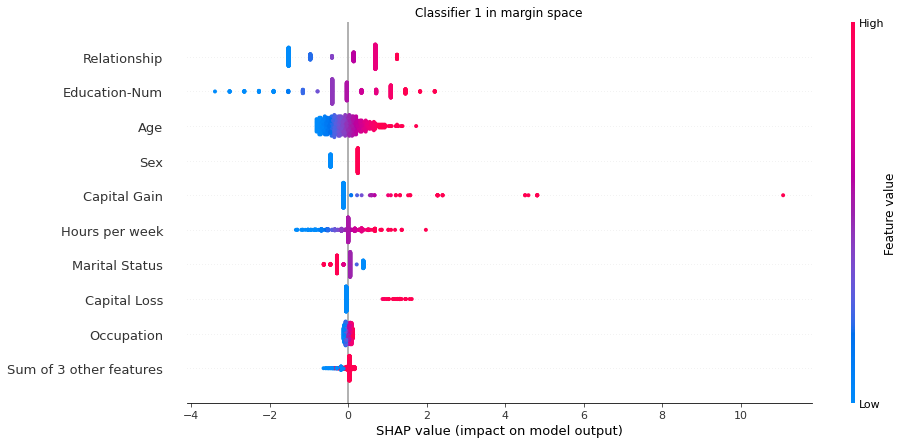

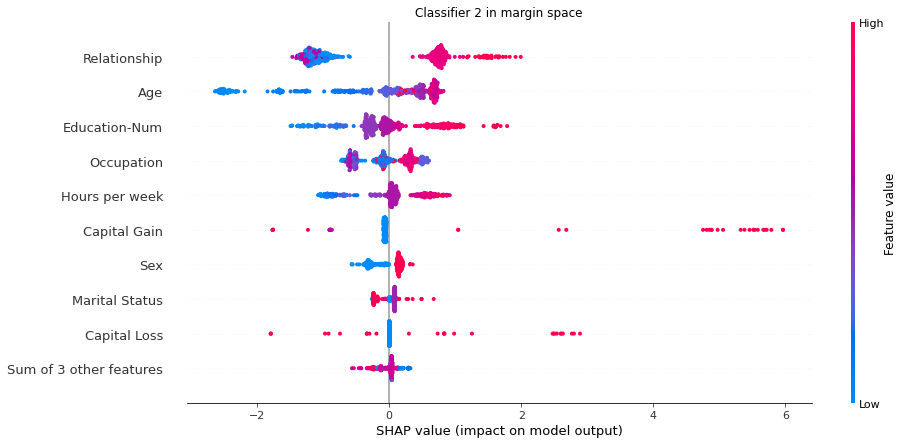

In [15]:
plot_shap_value_distribution(shap_values_f1, 'Classifier 1 in margin space')
plot_shap_value_distribution(shap_values_f2, 'Classifier 2 in margin space')

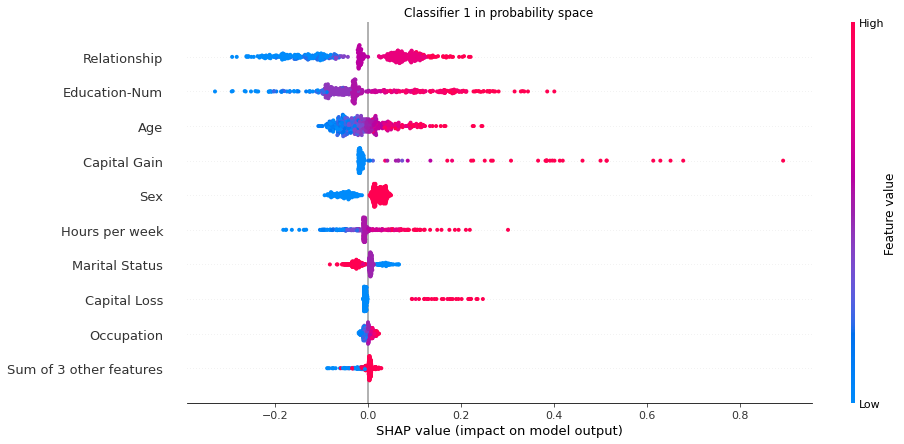

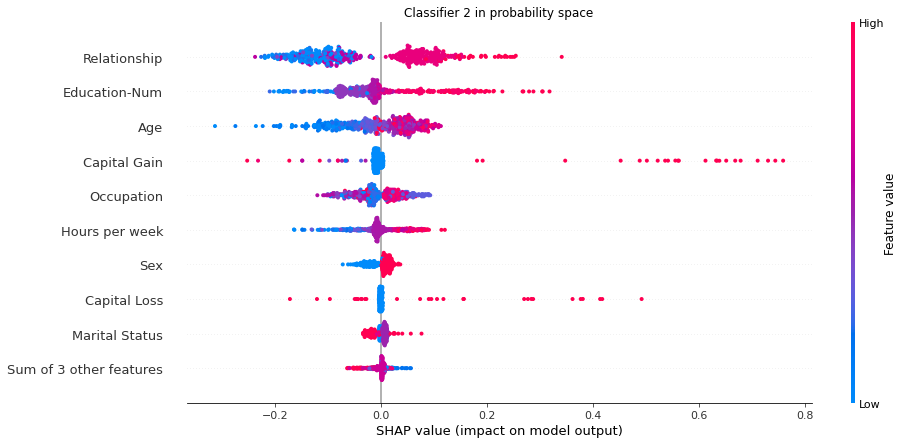

In [16]:
plot_shap_value_distribution(shap_values_c1, 'Classifier 1 in probability space')
plot_shap_value_distribution(shap_values_c2, 'Classifier 2 in probability space')

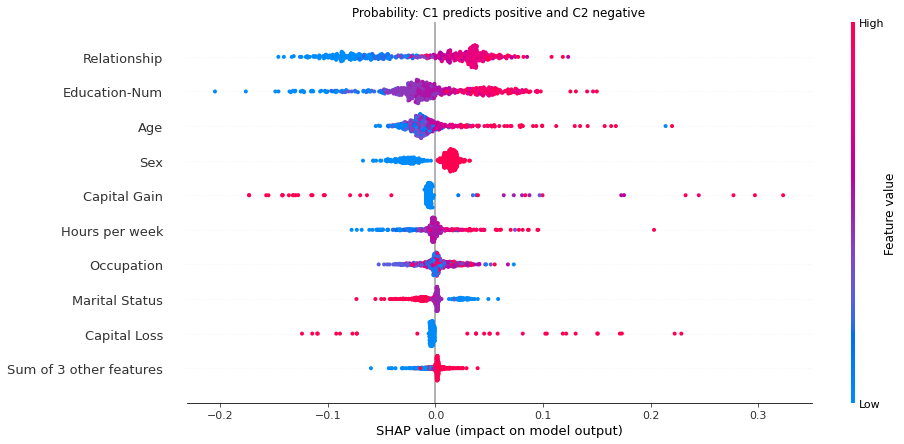

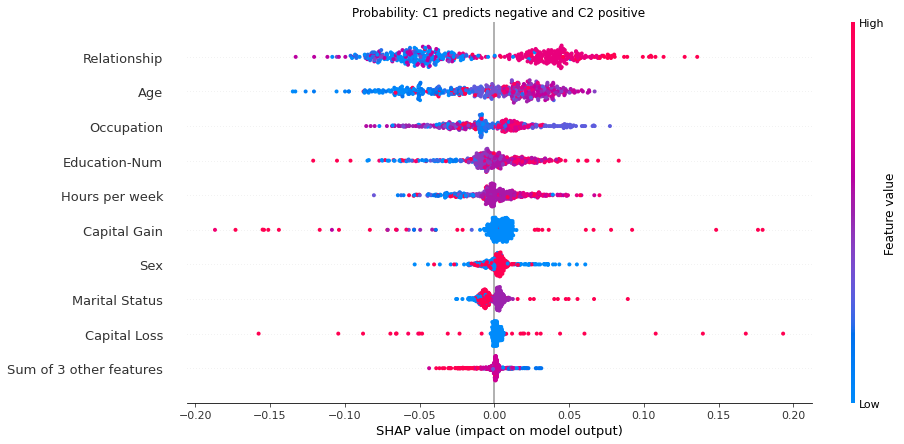

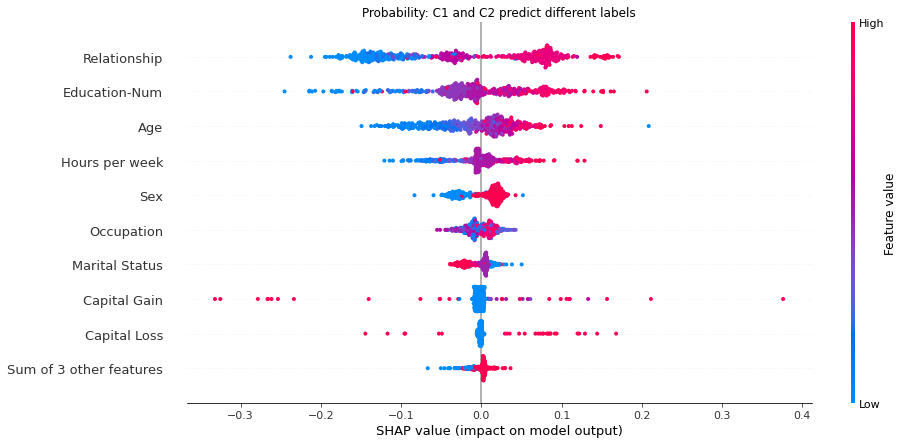

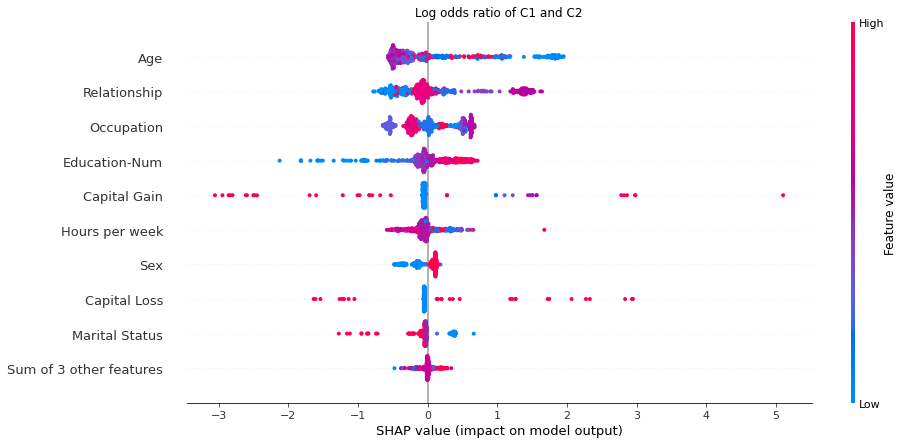

In [17]:
plot_shap_value_distribution(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_value_distribution(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_value_distribution(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels')
plot_shap_value_distribution(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')

### Features' Partial Dependence Plots

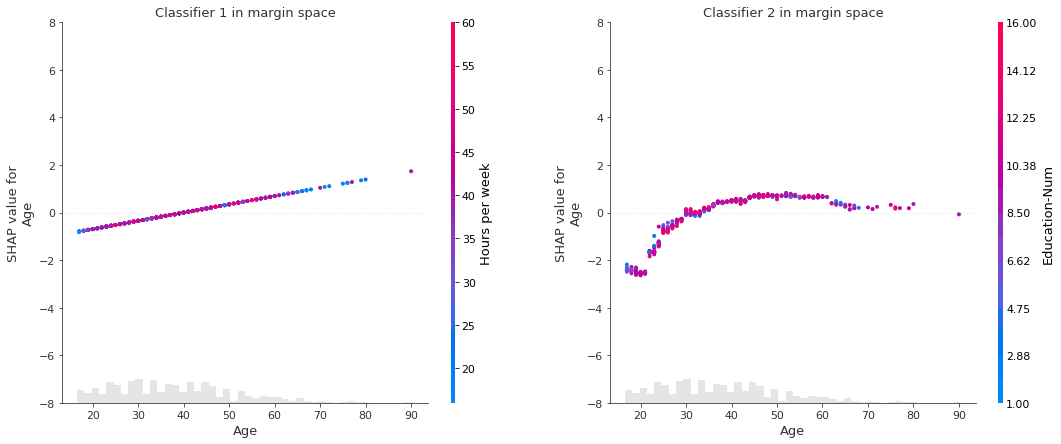

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_f1, feature_names[0], 'Classifier 1 in margin space', (-8, 8), axs[0])
plot_shap_partial_dependence(shap_values_f2, feature_names[0], 'Classifier 2 in margin space', (-8, 8), axs[1])
plt.show()

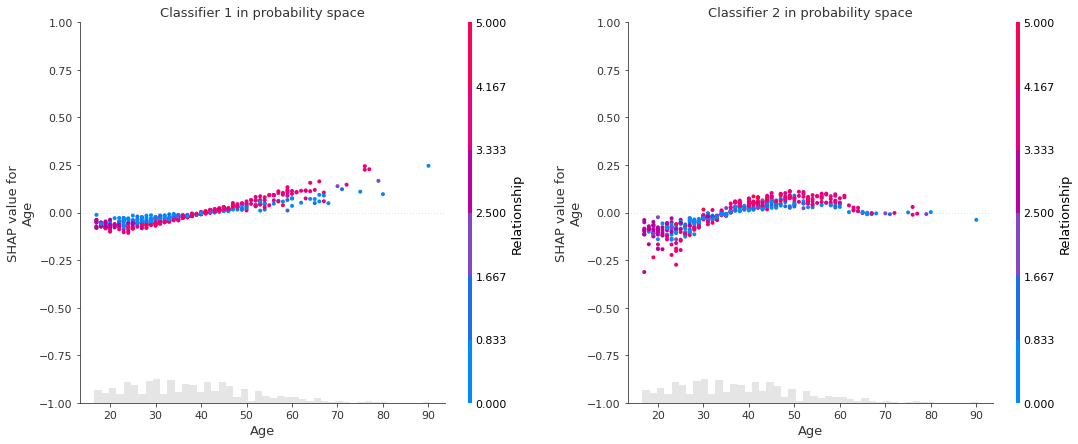

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_c1, feature_names[0], 'Classifier 1 in probability space', (-1, 1), axs[0])
plot_shap_partial_dependence(shap_values_c2, feature_names[0], 'Classifier 2 in probability space', (-1, 1), axs[1])
plt.show()

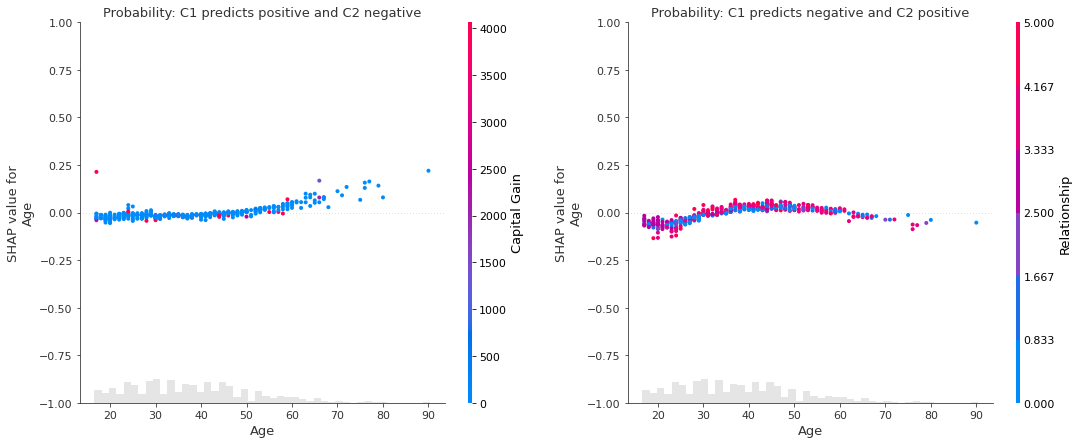

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_c_c1_positive_and_c2_negative, feature_names[0], 'Probability: C1 predicts positive and C2 negative', (-1, 1), axs[0])
plot_shap_partial_dependence(shap_values_c_c1_negative_and_c2_positive, feature_names[0], 'Probability: C1 predicts negative and C2 positive', (-1, 1), axs[1])
plt.show()

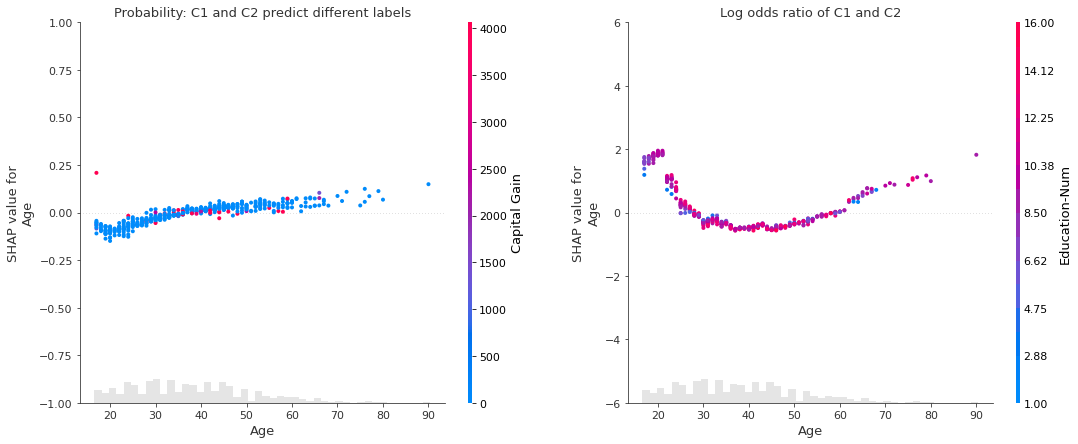

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_c_c1_and_c2_different, feature_names[0], 'Probability: C1 and C2 predict different labels', (-1, 1), axs[0])
plot_shap_partial_dependence(shap_values_f_log_odds_ratio, feature_names[0], 'Log odds ratio of C1 and C2', (-6, 6), axs[1])
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [22]:
ordering = plot_shap_values_stacked(shap_values_f1, 'Classifier 1 in margin space')
plot_shap_values_stacked(shap_values_f2, 'Classifier 2 in margin space', ordering);

In [23]:
ordering = plot_shap_values_stacked(shap_values_c1, 'Classifier 1 in probability space')
plot_shap_values_stacked(shap_values_c2, 'Classifier 2 in probability space', ordering);

In [24]:
plot_shap_values_stacked(shap_values_c_c1_positive_and_c2_negative, 'Probability: C1 predicts positive and C2 negative');

In [25]:
plot_shap_values_stacked(shap_values_c_c1_negative_and_c2_positive, 'Probability: C1 predicts negative and C2 positive');

In [26]:
plot_shap_values_stacked(shap_values_c_c1_and_c2_different, 'Probability: C1 and C2 predict different labels');

In [27]:
plot_shap_values_stacked(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2');

### Hierarchically Clustered SHAP Values

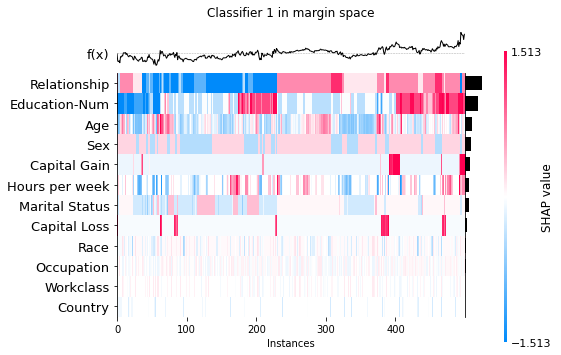

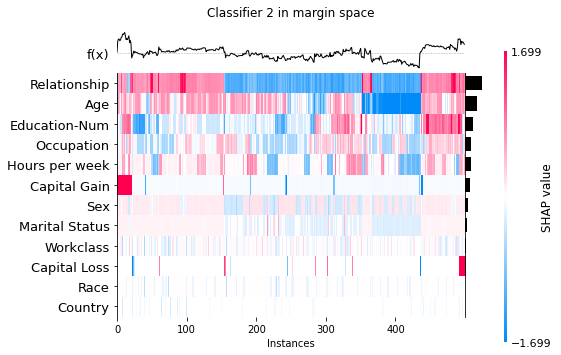

In [28]:
plot_shap_values_hierarchically_clustered(shap_values_f1, 'Classifier 1 in margin space')
plot_shap_values_hierarchically_clustered(shap_values_f2, 'Classifier 2 in margin space')

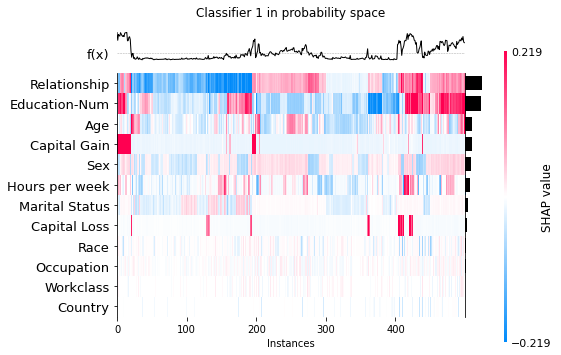

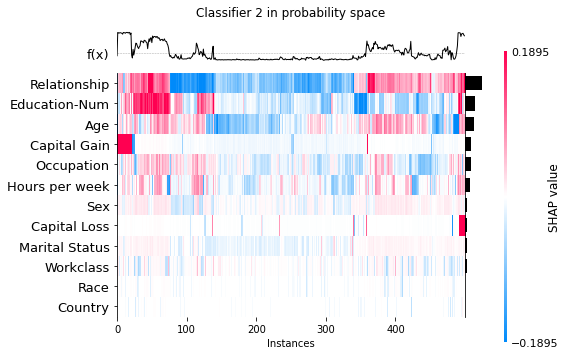

In [29]:
plot_shap_values_hierarchically_clustered(shap_values_c1, 'Classifier 1 in probability space')
plot_shap_values_hierarchically_clustered(shap_values_c2, 'Classifier 2 in probability space')

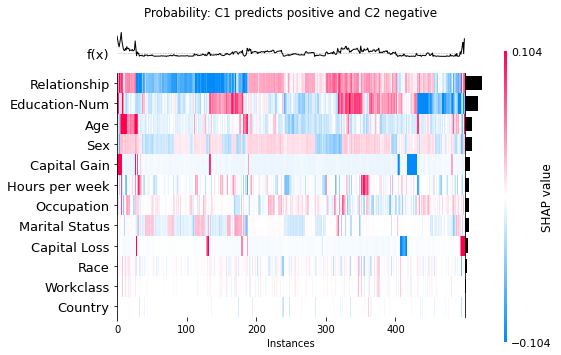

In [30]:
plot_shap_values_hierarchically_clustered(shap_values_c_c1_positive_and_c2_negative, 'Probability: C1 predicts positive and C2 negative')

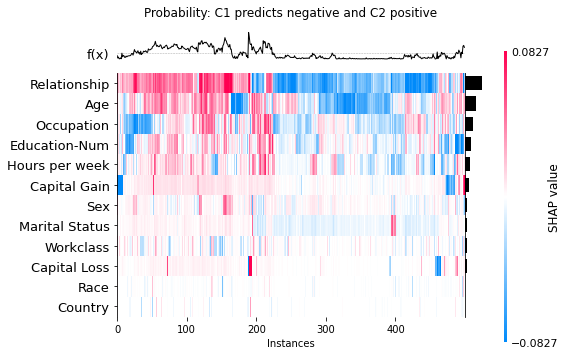

In [31]:
plot_shap_values_hierarchically_clustered(shap_values_c_c1_negative_and_c2_positive, 'Probability: C1 predicts negative and C2 positive')

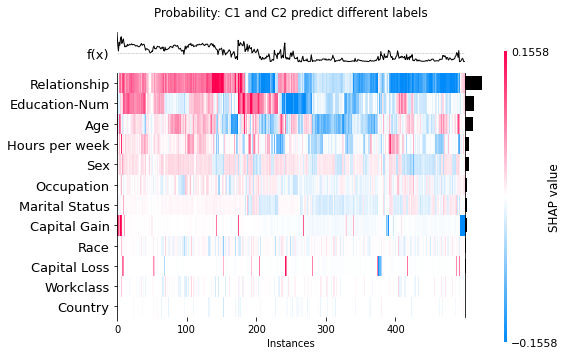

In [32]:
plot_shap_values_hierarchically_clustered(shap_values_c_c1_and_c2_different, 'Probability: C1 and C2 predict different labels')

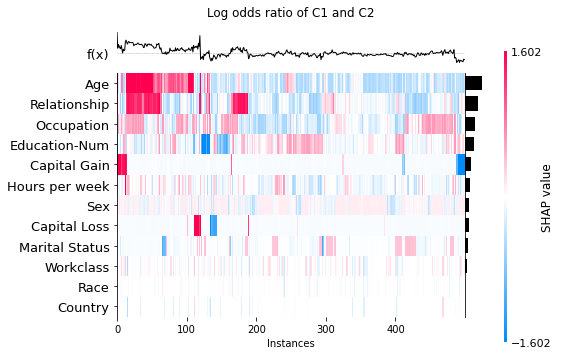

In [33]:
plot_shap_values_hierarchically_clustered(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')